### Import libraries

In [1]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [2]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.9.2


### Scaled Dot-Product Attention

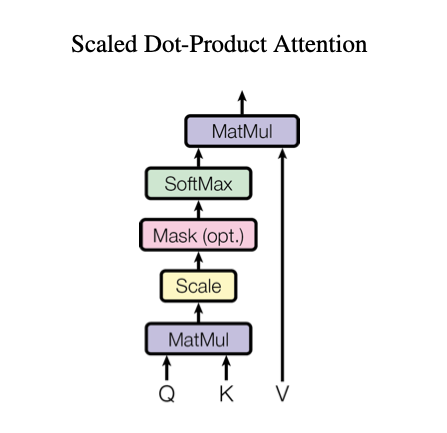

In [3]:
def scaled_dot_product_attention(q, k, v, mask=None, dropout=None):
    """
    Computes scaled dot-product attention.

    Args:
        q (tensor): Query tensor of shape (..., seq_len_q, depth_k).
        k (tensor): Key tensor of shape (..., seq_len_k, depth_k).
        v (tensor): Value tensor of shape (..., seq_len_v, depth_v).
        mask (tensor, optional): Optional mask for the attention weights.
                                 Shape broadcastable to (..., seq_len_q, seq_len_k).
        dropout (function, optional): Optional dropout function to be applied to attention weights.

    Returns:
        tuple: A tuple containing the attention output and the attention weights.
               Output shape is (..., seq_len_q, depth_v) and attention weights shape is (..., seq_len_q, seq_len_k).
    """
    # Compute the dot product of Q and K, transposing the last two dimensions of K
    matmul_qk = tf.matmul(q, k, transpose_b=True)  # shape: (..., seq_len_q, seq_len_k)

    # Scale the dot product by the square root of the depth of K
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # Apply the mask if provided
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)

    # Apply softmax to compute attention weights
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)

    # Apply dropout to the attention weights if provided
    if dropout is not None:
        attention_weights = dropout(attention_weights)

    # Multiply attention weights with V to get the output
    output = tf.matmul(attention_weights, v)

    return output, attention_weights

In [ ]:
# define the hyperparameters
batch_size = 128
seq_len_q = 32
seq_len_k = 16
depth_k = 64
depth_v = 256

# define the input tensors
query = tf.random.normal((batch_size, seq_len_q, depth_k))
key = tf.random.normal((batch_size, seq_len_k, depth_k))
value = tf.random.normal((batch_size, seq_len_k, depth_v))

print(f'Query tensor shape:\t{query.shape}')
print(f'Key tensor shape:\t{key.shape}')
print(f'Value tensor shape:\t{value.shape}')

# call the scaled dot-product operator
output, weights = scaled_dot_product_attention(query, key, value)

print(f'\nOutput tensor shape:\t{output.shape}')
print(f'Attention tensor shape:\t{weights.shape}')

Query tensor shape:	(128, 32, 64)
Key tensor shape:	(128, 16, 64)
Value tensor shape:	(128, 16, 256)

Output tensor shape:	(128, 32, 256)
Attention tensor shape:	(128, 32, 16)


### Multi-Head Attention

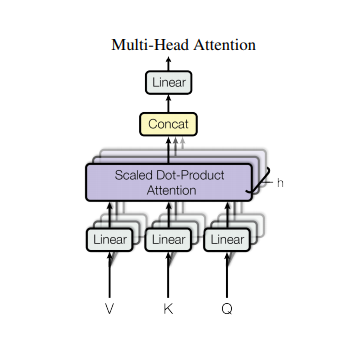

In [ ]:
class MultiHeadAttention(tfkl.Layer):
    def __init__(self, d_model, num_heads):
        """
        Initializes the MultiHeadAttention layer.

        Args:
            d_model (int): The dimensionality of the model.
            num_heads (int): The number of attention heads.
        """
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        # Ensure the model dimension is divisible by the number of heads
        assert d_model % self.num_heads == 0, "d_model must be divisible by num_heads"

        self.depth = d_model // self.num_heads

        # Dense layers for query, key, and value
        self.wq = tfkl.Dense(d_model)
        self.wk = tfkl.Dense(d_model)
        self.wv = tfkl.Dense(d_model)

        # Final dense layer to combine attention heads
        self.dense = tfkl.Dense(d_model)

    def scaled_dot_product_attention(self, q, k, v, mask, dropout):
        """
        Calculates scaled dot product attention.

        Args:
            q (Tensor): Query tensor of shape (..., seq_len_q, depth).
            k (Tensor): Key tensor of shape (..., seq_len_k, depth).
            v (Tensor): Value tensor of shape (..., seq_len_v, depth).
            mask (Tensor): Optional mask for attention weights.
            dropout (function): Optional dropout function.

        Returns:
            Tuple of (output, attention_weights)
        """
        matmul_qk = tf.matmul(q, k, transpose_b=True)

        # Scale the dot product
        dk = tf.cast(tf.shape(k)[-1], tf.float32)
        scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

        # Apply the mask if provided
        if mask is not None:
            scaled_attention_logits += (mask * -1e9)

        # Compute attention weights
        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)

        # Apply dropout if provided
        if dropout is not None:
            attention_weights = dropout(attention_weights)

        # Compute output
        output = tf.matmul(attention_weights, v)

        return output, attention_weights

    def split_heads(self, x, batch_size):
        """
        Splits the last dimension into (num_heads, depth) and rearranges the tensor.

        Args:
            x (Tensor): Input tensor.
            batch_size (int): Batch size of the input tensor.

        Returns:
            Tensor: Rearranged tensor of shape (batch_size, num_heads, seq_len, depth).
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask=None, dropout=None):
        """
        The forward pass for MultiHeadAttention.

        Args:
            v (Tensor): Value tensor.
            k (Tensor): Key tensor.
            q (Tensor): Query tensor.
            mask (Tensor, optional): Optional mask tensor.
            dropout (function, optional): Optional dropout function.

        Returns:
            Tuple of (output, attention_weights).
        """
        batch_size = tf.shape(q)[0]

        # Project and reshape the inputs
        q = self.split_heads(self.wq(q), batch_size)
        k = self.split_heads(self.wk(k), batch_size)
        v = self.split_heads(self.wv(v), batch_size)

        # Compute scaled attention and attention weights
        scaled_attention, attention_weights = self.scaled_dot_product_attention(q, k, v, mask, dropout)

        # Concatenate and project the attention outputs
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))
        output = self.dense(concat_attention)

        return output, attention_weights

In [ ]:
# define the hyperparameters
batch_size = 128
seq_len = 64
depth = 256
heads = 8
d_model = 256

# instantiate the class
multi_head_attention = MultiHeadAttention(d_model=d_model, num_heads=heads)

# define the input tensors
query = tf.random.normal((batch_size, seq_len, depth))
key = tf.random.normal((batch_size, seq_len, depth))
value = tf.random.normal((batch_size, seq_len, depth))

print(f'Query tensor shape:\t{query.shape}')
print(f'Key tensor shape:\t{key.shape}')
print(f'Value tensor shape:\t{value.shape}')

# call the multi-head attention layer
output, weights = multi_head_attention(query, key, value)

print(f'\nOutput tensor shape:\t{output.shape}')
print(f'Attention tensor shape:\t{weights.shape}')

Query tensor shape:	(128, 64, 256)
Key tensor shape:	(128, 64, 256)
Value tensor shape:	(128, 64, 256)

Output tensor shape:	(128, 64, 256)
Attention tensor shape:	(128, 8, 64, 64)


### TensorFlow2 MultiHeadAttention

In [ ]:
# Create a MultiHeadAttention layer via TensorFlow2 Class
multi_head_attention = tf.keras.layers.MultiHeadAttention(num_heads=heads, key_dim=d_model//heads)

# Define the input tensors
query = tf.random.normal((batch_size, seq_len, depth))
key = tf.random.normal((batch_size, seq_len, depth))
value = tf.random.normal((batch_size, seq_len, depth))

print(f'Query tensor shape:\t{query.shape}')
print(f'Key tensor shape:\t{key.shape}')
print(f'Value tensor shape:\t{value.shape}')

# Call the multi-head attention layer
output, weights = multi_head_attention(query, key, value, return_attention_scores=True)

print(f'\nOutput tensor shape:\t{output.shape}')
print(f'Attention tensor shape:\t{weights.shape}')

Query tensor shape:	(128, 64, 256)
Key tensor shape:	(128, 64, 256)
Value tensor shape:	(128, 64, 256)

Output tensor shape:	(128, 64, 256)
Attention tensor shape:	(128, 8, 64, 64)


*Credits: Eugenio Lomurno, 📧 eugenio.lomurno@polimi.it*